**This notebook belongs to Engin Deniz ALPMAN.**

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

In [3]:
import math

In [4]:
PATH= Path('data/mnist/')

## Reading Data

## Scandir

* Scandir gives us an iterator that we can iterate that will give us the properties of the folder

In [5]:
PATH

WindowsPath('data/mnist')

In [6]:
[f.name for f in os.scandir(PATH)]

['train', 'validation']

In [7]:
s = [f.name for f in os.scandir(PATH/"train/1")][0]

In [8]:
[f.name for f in os.scandir(PATH/"train/1")][0]

'img_10006.jpg'

In [9]:
s.split(".")

['img_10006', 'jpg']

In [197]:
def _get_files(p, fs, extensions = None):
    p = Path(p) # to support / notation
    res = [p/f for f in fs if not f.startswith(".") 
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [198]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e)).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [199]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

data\mnist\train\0
data\mnist\train\1
data\mnist\train\2
data\mnist\train\3
data\mnist\train\4
data\mnist\train\5
data\mnist\train\6
data\mnist\train\7
data\mnist\train\8
data\mnist\train\9


In [200]:
val_x,val_y = create_ds_from_file(PATH/"validation")

data\mnist\validation\0
data\mnist\validation\1
data\mnist\validation\2
data\mnist\validation\3
data\mnist\validation\4
data\mnist\validation\5
data\mnist\validation\6
data\mnist\validation\7
data\mnist\validation\8
data\mnist\validation\9


## Normalization

In general you will normalize your data. It helps our model in learning (explain why in detail)

* Why didn't we normalize independent variables in random forest ? (it also explain why random forests are robust to outliers)

* We will normalize by pixels

* If we had more than 1 channel we would normally normalize by channel so that we would have 1 mean std for Red, 1 mean std for Green, 1 mean std for Blue



* Generally you need specific normalization parameters for each things that you expect to behave differently

* We will normalize validation and test set using the mean and std of training set!

* If we normalize them seperately, it is like pixel value 3 has different meaning when the pixel value is 3 in validation set

In [201]:
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(34.3409), tensor(77.5014), tensor(7.4670e-06), tensor(1.))

In [202]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0042), tensor(1.0038))

## Look at the Data

In [203]:
def show(img, title):
    plt.imshow(img, cmap="gray")
    plt.title(title.item())

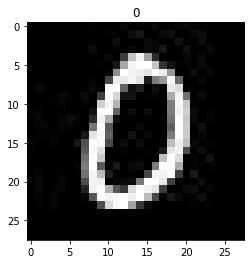

In [204]:
show(trn_x[2].view(28,28), val_y[2])

### View more than one image

* fig.add_subplot(221) means 2x2 grid at subplot 1

* fig.add_subplot(232) means 2x3 grid at subplot 2 etc..

* to make this plot: [link of the code](https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111)
```Python
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(221)   #top left
fig.add_subplot(222)   #top right
fig.add_subplot(223)   #bottom left
fig.add_subplot(224)   #bottom right 
plt.show()
```  

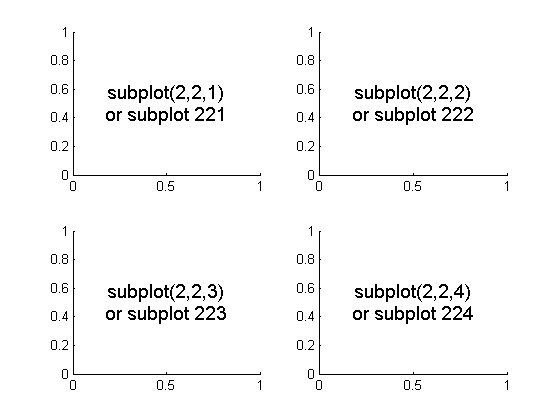

In [205]:
def plots(ims, titles, figsize = (12, 6), rows = 2):
    fig = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    
    for i in range(len(ims)):
        sp = fig.add_subplot(rows, cols, i+1)
        # sp.axis("Off")
        sp.set_title(titles[i].item())
        plt.imshow(ims[i].view(28,28), cmap="gray")

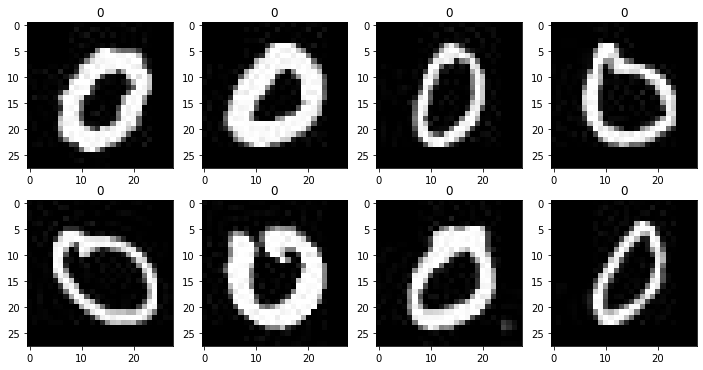

In [206]:
plots(trn_x[:8], titles=val_y[:8])

* You can customize this function and use it for viewing batch

## Dataset and DataLoader

In [207]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [208]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [209]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

## Softmax

In [210]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

## Negative log likelihood

### Fancy Indexing

In [211]:
predictions = np.random.rand(5,10)

In [212]:
predictions

array([[0.36583394, 0.44557053, 0.92647969, 0.47847072, 0.73092423,
        0.72187041, 0.55715903, 0.29676314, 0.30290249, 0.7843437 ],
       [0.62458802, 0.03124816, 0.01765255, 0.44527857, 0.78731931,
        0.00470887, 0.65602458, 0.83580912, 0.21766279, 0.26253232],
       [0.22030701, 0.96651986, 0.22548466, 0.71314349, 0.85272394,
        0.77039896, 0.40490003, 0.37485065, 0.31965946, 0.72976834],
       [0.09483731, 0.68277941, 0.31786886, 0.52789521, 0.74998705,
        0.39123386, 0.31237347, 0.23949082, 0.70008007, 0.31914741],
       [0.94864308, 0.0247422 , 0.9126308 , 0.07167832, 0.46455455,
        0.75063022, 0.80293916, 0.09604156, 0.22770211, 0.602965  ]])

In [213]:
actuals = np.array([0,3,1,1,9])

In [214]:
actuals

array([0, 3, 1, 1, 9])

In [215]:
predictions.dtype

dtype('float64')

In [216]:
predictions[range(actuals.shape[0]), actuals]

array([0.36583394, 0.44527857, 0.96651986, 0.68277941, 0.602965  ])

### nll

* preds[range(actuals.shape[0]), actuals] will give us predictions of true values

In [217]:
def nll(preds, actuals): 
    return -preds[range(actuals.shape[0]), actuals].mean() 

## Accuracy

In [218]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [219]:
def accuracy(preds, yb): 
    return (torch.argmax(preds, dim=1, keepdim = True)==yb).float().mean()

## Training our model

In [220]:
def loss_func(preds, actuals):
    preds = log_softmax(preds)
    return nll(preds, actuals)

In [221]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.squeeze())
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))

In [222]:
model = nn.Sequential(
    nn.Linear(28*28,10)
).cuda()

In [227]:
model = nn.Sequential(
    nn.Linear(28*28,60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [228]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)

In [229]:
train(model,100,10)

0.3435683250427246
0.8260356187820435
0.8690043687820435
0.8850835561752319
0.8905341625213623
0.8965297937393188
0.8977107405662537


KeyboardInterrupt: 

### Overfitting

In [162]:
model = nn.Sequential(
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.Linear(100, 60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [163]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [164]:
train(model,300,30)

0.28997093439102173
0.9445857405662537
0.9622092843055725
0.968204915523529
0.9691133499145508
0.9702943563461304
0.9708393812179565
0.9719294905662537
0.9702943563461304
0.10138081014156342


KeyboardInterrupt: 

## Regularization

* Why to use Regularization ?

In [124]:
model = nn.Sequential(
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.Linear(100, 60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [125]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [126]:
train(model,300,30)

0.26871365308761597
0.9400436282157898
0.9589389562606812
0.9663881063461304
0.9703851938247681


KeyboardInterrupt: 